# Map of Covid-19 Cases in São Paulo - Brazil

Este caderno é direcionado à produção de um mapa das mortes e casos em todo o estado devido ao Covid-19.


Como principal fonte de dados, usaremos os dados oficiais da Secretaria de Saúde do Estado, disponibilizados em https://www.seade.gov.br/coronavirus/.

Para os limites municipais, usaremos o conjunto de dados de municípios de São Paulo do catálogo de dados do Banco Mundial (https://datacatalog.worldbank.org/dataset/sao-paulo-municipalities) 


In [1]:
import pandas as pd
import ssl
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et



In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
dados_de_covid_por_municipio = pd.read_csv(
    "http://www.seade.gov.br/wp-content/uploads/2020/05/Dados-covid-19-municipios.csv",
    sep = ";",
    encoding = "latin" )

dados_de_covid_por_municipio.head(4)

,Cód. IBGE,Grande região,Município,Mun_Total de casos,Mun_Total de óbitos,Unnamed: 5,Unnamed: 6
0,3500105,Interior,Adamantina,7,0,NaN,NaN
1,3500204,Interior,Adolfo,1,0,NaN,NaN
2,3500303,Interior,Aguaí,15,2,NaN,NaN
3,3500402,Interior,Águas da Prata,1,0,NaN,NaN


In [3]:
# Importando o shapefile com geopandas

mapa_dos_municipios_de_sp = gpd.read_file("shapefiles/sao_paulo.shp")

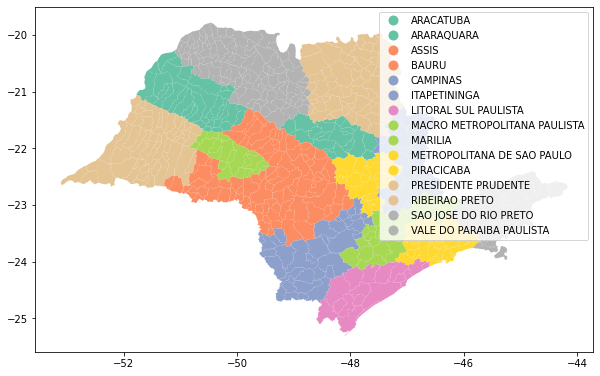

In [4]:
fig, ax = plt.subplots(figsize = (10,10))

# Plotando o mapa só para ver como fica

mapa_dos_municipios_de_sp.plot(column='NOMEMESO', 
                         categorical=True, 
                         legend=True, 
                         figsize=(10,6),
                         markersize=45, 
                         cmap="Set2", ax=ax);

In [9]:
mapa_dos_municipios_de_sp["CODMUNIC"] = mapa_dos_municipios_de_sp["CODMUNIC"].astype(float)
mapa_dos_municipios_de_sp_com_dados = mapa_dos_municipios_de_sp.merge(dados_de_covid_por_municipio, left_on="CODMUNIC", right_on="Cód. IBGE", how = "left")
mapa_dos_municipios_de_sp_com_dados["CODMUNIC"]


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
645    3556305.0
646    3557105.0
647    3557154.0
648    3557204.0
649    3557303.0
Name: CODMUNIC, Length: 650, dtype: float64

In [10]:
mapa_dos_municipios_de_sp_com_dados["Mun_Total de óbitos"] = mapa_dos_municipios_de_sp_com_dados["Mun_Total de óbitos"].fillna(0)
mapa_dos_municipios_de_sp_com_dados["Mun_Total de casos"] = mapa_dos_municipios_de_sp_com_dados["Mun_Total de casos"].fillna(0)

mapa_dos_municipios_de_sp_com_dados["obitos_categorizados"] = pd.cut(mapa_dos_municipios_de_sp_com_dados["Mun_Total de óbitos"],
                                                    bins = [-1,1,3,6,10,50,200, 100000000],
                                                   labels = ["a) 0", "b) 1-3", "c) 4-6", "d) 6-10", "e) 11-50","f) 51-200", "g) >201"])

mapa_dos_municipios_de_sp_com_dados["casos_categorizados"] = pd.cut(mapa_dos_municipios_de_sp_com_dados["Mun_Total de casos"],
                                                    bins = [-1,1, 10,50,500,1000, 100000000],
                                                   labels = ["a) 0", "b) 1-10", "c) 11-50", "d) 51-500","e) 501-1000", "f) >1000"])

In [11]:
# Encontrando a data da tabela
# Assumindo que a tabela do estado e a tabela do município são atualizadas ao mesmo tempo


ssl._create_default_https_context = ssl._create_unverified_context
dados_de_covid_do_estado = pd.read_csv(
    "http://www.seade.gov.br/wp-content/uploads/2020/05/Dados-covid-19-estado.csv",
    sep = ";",
    encoding = "latin" )

dados_de_covid_do_estado.head(4)


,Data,Total de casos,Casos por dia,Óbitos por dia,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,26 fev,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,27 fev,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,28 fev,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,29 fev,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:

datas_registradas = dados_de_covid_do_estado["Data"][dados_de_covid_do_estado["Data"].notnull()]

data_dos_dados = datas_registradas.values[-1]
data_dos_dados_sem_espaco = data_dos_dados.replace(" ", "_")

In [13]:
def plote_mapa_de_sp_com_dados(tabela_geopandas, coluna_dos_dados):
    fig, ax = plt.subplots()
    ax = mapa_dos_municipios_de_sp_com_dados.plot(column=coluna_dos_dados,
                         categorical=True, 
                         legend=True, 
                         figsize=(10,6),
                         markersize=45,
                         cmap = "Reds",
                         edgecolor='k',
                         linewidth=0.1,
                         ax=ax);
    # Removendo os eixos x e y para ficar mais bonitinho
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    

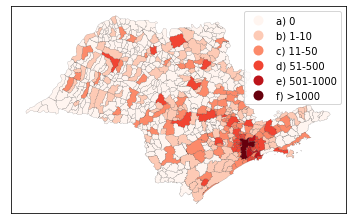

In [14]:
plote_mapa_de_sp_com_dados(mapa_dos_municipios_de_sp_com_dados, "casos_categorizados")
arquivo_figura_casos = "fig/casos_sp_" + data_dos_dados_sem_espaco + ".png"
plt.savefig(arquivo_figura_casos, dpi=300,transparent=True)

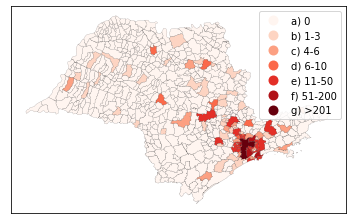

In [15]:
plote_mapa_de_sp_com_dados(mapa_dos_municipios_de_sp_com_dados, "obitos_categorizados")
arquivo_figura_obitos = "fig/obitos_sp_" + data_dos_dados_sem_espaco + ".png"
plt.savefig(arquivo_figura_obitos, dpi=300,transparent=True)


In [16]:
import datetime
from datetime import date, timedelta

today = date.today()
today_in_wikidata_format = today.strftime("+%Y-%m-%dT00:00:00Z/11")

today_in_commons_format = today.strftime("%Y-%m-%d")

print(today_in_commons_format)

2020-05-06


In [17]:
# Auto commons upload via pywikibot
# pip3 install pywikibot
# set config file as described in https://www.mediawiki.org/wiki/Manual:Pywikibot/user-config.py#ExampleBot_on_Commons




place = "estado de São Paulo"
data_dos_dados = data_dos_dados # See above for the definition. 


descrevendo_obitos  = '''=={{int:filedesc}}==
{{Information
|description={{pt|1=Óbitos por COVID-19 por município no '''+ place + " até o dia " + data_dos_dados + ''' de 2020.  Gráfico em Python gerado a partir dos dados de [https://www.seade.gov.br/coronavirus/]. Script disponível em github.com/lubianat/wikidata_covid19/tree/master/sandbox/distribution_maps}}.
|date=''' + today_in_commons_format + '''
|source={{own}}
|author=[[User:TiagoLubiana|TiagoLubiana]]
|permission=
|other versions=
}}

=={{int:license-header}}==
{{self|cc-by-sa-4.0}}

[[Category:Maps about the COVID-19 pandemic in São Paulo (state)]]
'''



arquivo_descrevendo_obitos = "fig/description_deaths_" + data_dos_dados_sem_espaco + ".txt"

file1 = open(arquivo_descrevendo_obitos,"w") 
file1.write(descrevendo_obitos)
file1.close()


descrevendo_casos  = '''=={{int:filedesc}}==
{{Information
|description={{pt|1=Casos de COVID-19 por município no '''+ place + " até o dia " + data_dos_dados + ''' de 2020.  Gráfico em Python gerado a partir dos dados de [https://www.seade.gov.br/coronavirus/]. Script disponível em github.com/lubianat/wikidata_covid19/tree/master/sandbox/distribution_maps}}.
|date=''' + today_in_commons_format + '''
|source={{own}}
|author=[[User:TiagoLubiana|TiagoLubiana]]
|permission=
|other versions=
}}

=={{int:license-header}}==
{{self|cc-by-sa-4.0}}

[[Category:Maps about the COVID-19 pandemic in São Paulo (state)]]
'''

arquivo_descrevendo_casos = "fig/description_cases_" + data_dos_dados_sem_espaco + ".txt"

print(descrevendo_casos)
file2 = open(arquivo_descrevendo_casos,"w") 
file2.write(descrevendo_casos) 
file2.close()


=={{int:filedesc}}==
{{Information
|description={{pt|1=Casos de COVID-19 por município no estado de São Paulo até o dia 05 mai de 2020.  Gráfico em Python gerado a partir dos dados de [https://www.seade.gov.br/coronavirus/]. Script disponível em github.com/lubianat/wikidata_covid19/tree/master/sandbox/distribution_maps}}.
|date=2020-05-06
|source={{own}}
|author=[[User:TiagoLubiana|TiagoLubiana]]
|permission=
|other versions=
}}

=={{int:license-header}}==
{{self|cc-by-sa-4.0}}

[[Category:Maps about the COVID-19 pandemic in São Paulo (state)]]



In [18]:
# Change your Wikimedia user name in the user-config.py
# code for command line (interactive):

command_cases = "yes N | python3 upload.py -keep -filename " +  arquivo_figura_casos +  ' -summary:"updating status for today"' + " $(cat " +  arquivo_descrevendo_casos + ")"
command_deaths ="yes N | python3 upload.py -keep -filename " +  arquivo_figura_obitos +  ' -summary:"updating status for today"' + " $(cat " +  arquivo_descrevendo_obitos + ")"


print(command_cases)
print(command_deaths)

! $command_cases
! $command_deaths

yes N | python3 upload.py -keep -filename fig/casos_sp_05_mai.png -summary:"updating status for today" $(cat fig/description_cases_05_mai.txt)
yes N | python3 upload.py -keep -filename fig/obitos_sp_05_mai.png -summary:"updating status for today" $(cat fig/description_deaths_05_mai.txt)
/home/lubianat/.local/lib/python3.6/site-packages/pywikibot/config2.py:1091: UserWarning: 
Configuration variable "use_api_login" is defined in your user-
config.py but unknown. It can be a misspelled one or a variable that
is no longer supported.
  'supported.'.format(name)), UserWarning)
['fig/casos_sp_05_mai.png']
The suggested description is:
=={{int:filedesc}}== {{Information |description={{pt|1=Casos de COVID-19 por município no estado de São Paulo até o dia 05 mai de 2020. Gráfico em Python gerado a partir dos dados de [https://www.seade.gov.br/coronavirus/]. Script disponível em github.com/lubianat/wikidata_covid19/tree/master/sandbox/distribution_maps}}. |date=2020-05-06 |source={{own}} |author

In [19]:
# Now add via quickstatements ? TO BE DONE|

# Get current maps:

from wikidataintegrator import wdi_core

my_first_wikidata_item = wdi_core.WDItemEngine(wd_item_id='Q89713663')

In [20]:
commons_file_casos = "casos_sp_" + data_dos_dados_sem_espaco + ".png"
commons_file_obitos = "obitos_sp_" + data_dos_dados_sem_espaco + ".png"

def print_removing_map_statements(claim_property):
    value = (claim_property["mainsnak"]["datavalue"]["value"])
    if value != commons_file_casos and value != commons_file_obitos: 
        print(" -Q89713663|P1846|"+ '"' + value + '"')


[ print_removing_map_statements(i) for i in my_first_wikidata_item.get_wd_json_representation()["claims"]["P1846"]]




      
reference = '|S854|"https://www.seade.gov.br/coronavirus/"' + "|S813|" + today_in_wikidata_format

start_date = '|P585|' + '+2020-04-' + data_dos_dados[:2] +'T00:00:00Z/11'

print(" Q89713663|P1846|"+ '"' + commons_file_casos + '"' + start_date + reference)
print(" Q89713663|P1846|"+ '"' + commons_file_obitos + '"' + start_date + reference)      

 -Q89713663|P1846|"Casos sp 04 mai.png"
 -Q89713663|P1846|"Obitos sp 04 mai.png"
 Q89713663|P1846|"casos_sp_05_mai.png"|P585|+2020-04-05T00:00:00Z/11|S854|"https://www.seade.gov.br/coronavirus/"|S813|+2020-05-06T00:00:00Z/11
 Q89713663|P1846|"obitos_sp_05_mai.png"|P585|+2020-04-05T00:00:00Z/11|S854|"https://www.seade.gov.br/coronavirus/"|S813|+2020-05-06T00:00:00Z/11


In [28]:
# Let's auto upload them to Wikidata via the Wikidata Integrator

from wikidataintegrator import wdi_core, wdi_login
import os


WDUSER = os.getenv("WDUSER")
WDPASS = os.getenv("WDPASS")
login_instance = wdi_login.WDLogin(user=WDUSER, pwd=WDPASS)


reference_url_wdi = wdi_core.WDString(value="https://www.seade.gov.br/coronavirus/", prop_nr='P854', is_reference = True)
reference_access_wdi = wdi_core.WDTime(time=today_in_wikidata_format, prop_nr='P813', is_reference = True)
set_of_references = [[reference_url_wdi, reference_access_wdi ]]

point_in_time = '+2020-04-' + data_dos_dados[:2] +'T00:00:00Z/11'

point_in_time_wdi = wdi_core.WDTime(time=point_in_time, prop_nr='P585', is_qualifier = True)

case_map = wdi_core.WDString(value='casos_sp_28_abr.png', prop_nr='P1846', references = set_of_references, qualifiers = [point_in_time_wdi] )
death_map = wdi_core.WDString(value='obitos_sp_28_abr.png', prop_nr='P1846', references = set_of_references, qualifiers = [point_in_time_wdi] )


statement_list = [case_map, death_map]

wd_item = wdi_core.WDItemEngine(wd_item_id = "Q89713663", data = statement_list )
wd_item.write(login_instance, bot_account=False)

https://www.wikidata.org/w/api.php
Successfully logged in as TiagoLubiana
2020-04-30 10:24:57.815078: maxlag. sleeping for 7.983333333333333 seconds
2020-04-30 10:25:06.721664: maxlag. sleeping for 6.566666666666666 seconds


KeyboardInterrupt: 

In [23]:
today_in_wikidata_format

'+2020-04-30T00:00:00Z/11'